# Logistic regression

Logistic regression is arguably the most famous and well used classifier. It _is_ a regression, but don't let that confuse you: it estimates probabilities of class membership.

---

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm

In [3]:
colors = {'blue': '#729ECE',
          'brown': '#A8786E',
          'green': '#67BF5C',
          'grey': '#A2A2A2',
          'orange': '#FF9E4A',
          'pink': '#ED97CA',
          'purple': '#AD8BC9',
          'red': '#ED665D',
          'teal': '#6DCCDA',
          'yellow': '#CDCC5D'}

In [4]:
admissions = pd.read_csv('../Datasets/admissions.csv')

In [5]:
admissions.dropna(inplace=True)

In [15]:
admit = admissions[admissions.prestige == 1]

admit = pd.concat([admit]*20, axis=0)

admit.loc[admit.admit == 1, 'gpa'] += np.random.random(size=admit[admit.admit == 1].shape[0])
admit.loc[admit.admit == 0, 'gpa'] -= np.random.random(size=admit[admit.admit == 0].shape[0])

In [16]:
admit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1220 entries, 2 to 385
Data columns (total 4 columns):
admit       1220 non-null int64
gre         1220 non-null float64
gpa         1220 non-null float64
prestige    1220 non-null float64
dtypes: float64(3), int64(1)
memory usage: 47.7 KB


---

### 1. A (brief) review of regression models

To understand how logistic regression works, we need to understand least squares regression. 

As you are all familiar with, a regression with variable(s) matrix $X$ predicting target $y$ is formulated as:

### $$E(y|X) = \beta_0 + \sum_{j}^p\beta_jx_j$$

Where:
- $E(y|X)$ is the expected value (mean) of y given variable matrix $X$
- $\sum_{j}^p$ are the predictors $j$ thru $p$ (columns) of the $X$ matrix
- $beta_0$ is the intercept
- $beta_j$ is the coefficient for the predictor $x_j$, the $j$th column in variable matrix $X$

---

### 2. What if we predicted `admit` with `gpa` using regression?

In [22]:
#print 'Intercept:', linmod.intercept_
#print 'Coef(s):', linmod.coef_
y = admit['admit'].values
x = admit[['gpa']].values

linmod = LinearRegression()
linmod.fit(x,y)
linmod.coef_

array([ 0.50946639])

---

### 3. What do those coefficients mean?  Plot admit ~ gpa

What is the apparent problem with regression?

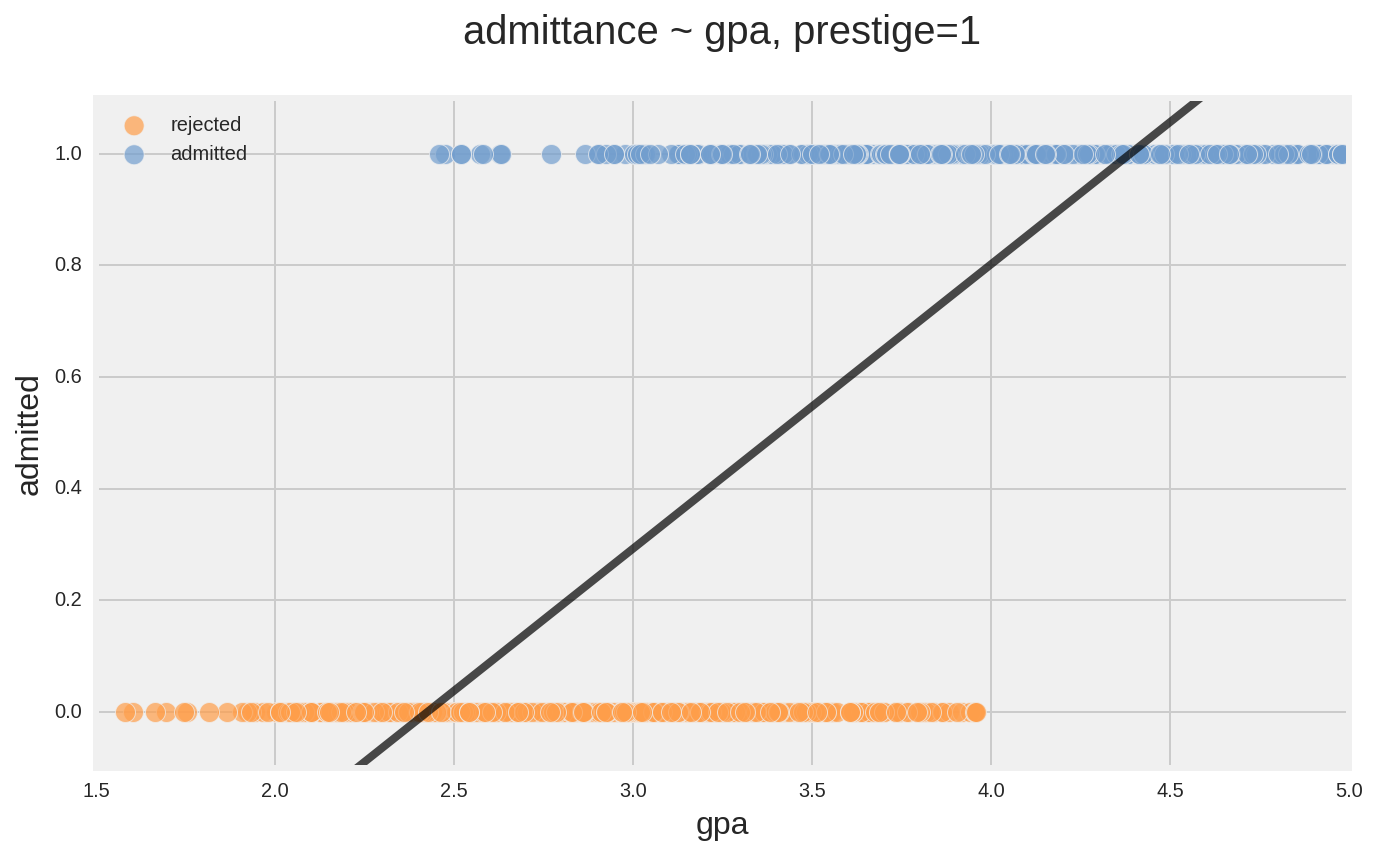

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
#fig.set_size_inches(6,5)

# plot the regression line for admit ~ gpa
x_vals = np.linspace(1.,5.,300)
ax.plot(x_vals, linmod.predict(x_vals[:, np.newaxis]),
        color='black', alpha=0.7, lw=4)

# do one scatter plot for each type of wine:
ax.scatter(admit.gpa[admit.admit == 0],
           admit.admit[admit.admit == 0],
           c=colors['orange'], s=100, alpha=0.7,
           label='rejected')

ax.scatter(admit.gpa[admit.admit == 1],
           admit.admit[admit.admit == 1],
           c=colors['blue'], s=100, alpha=0.7,
           label='admitted')

ax.set_ylabel('admitted', fontsize=16)
ax.set_xlabel('gpa', fontsize=16)
ax.set_title('admittance ~ gpa, prestige=1\n', fontsize=20)

ax.set_xlim([1.5,5])
ax.set_ylim(-0.1, 1.1)

plt.legend(loc='upper left')
plt.show()

---

### 5. Binary classes case

Logistic regression can solve multi-class problems – we will look at this another day – but the basic classification problem is binary. 

In our case, `1=admitted` and `0=rejected`.

The logistic regression is still solving for an expected value. In the binary classification case this expected value is the probability of one class:

### $$E[y \in {0,1}] = P(y = 1)$$

In regression syntax we would have:

### $$P(y = 1) = \beta_0 + \sum_{j}^p\beta_jx_j$$

---

### 6. The dilemma: probability estimation using regression

### $$P(y = 1) = \beta_0 + \sum_{j}^p\beta_jx_j$$

There is an important problem with this new equation: we want to estimate a probability instead of a real number.

Why is this a problem?


#### We need $y$ to fall in the range `[-infinity, infinity]` for the regression to be valid!

---

### 4. The logit "link function"

As the name implies, logistic regression is still a regression. It can still be solved by minimization of the sum of squared errors, and there is still an intercept and coefficients.

Logistic regression is a twist on regression for categorical/class target variables. Instead of solving for the _mean_ of $y$, logistic regression solves for the _probability of class membership_ of $y$.

How does it do this? Regressions can be generalized to $y$ targets that do not fall between `[-infinity, infinity]` through the use of **link functions**.

A link function is simply a function of the expected value of the target variable:

### $$logit(E(y | X)) = \beta_0 + \sum_{j}^p\beta_jx_j$$

1. Probabilities are guaranteed to be between 0 and 1.
2. The regression formula makes no guarantee that the sum of predictors multiplied by coefficients will sum to a value between 0 and 1.

---

### 7. Step 1: Odds ratios

We have to modify the regression for it to work for predicting probabilities. The initial step in the solution depends on the use of **odds ratios**. Before we get into _why_, it's important to understand what an odds ratio is.

Probabilities and odds ratios represent the same thing in different ways. Probabilities can be alternatively expressed as odds ratios. The odds ratio for probability **p** is defined:

### $$\text{odds ratio}(p) = \frac{p}{1-p}$$

The odds ratio of a probability is a measure of how many times more likely it is than the inverse case.

For example:

- When **`p = 0.5`**: **`odds ratio = 1`**
    - it is equally likely to happen as it is to not happen.
- When **`p = 0.75`**: **`odds ratio = 3`**
    - it is 3 times more likely to happen than not happen.
- When **`p = 0.40`**: **`odds ratio = 0.666..`**
    - it is 2/3rds as likely to happen than not happen.

#### What are the probabilities of admittance by prestige?

In [8]:
# print 'P(admit | prestige = 1):', #?
# print 'P(admit | prestige = 2):', #?
# print 'P(admit | prestige = 3):', #?
# print 'P(admit | prestige = 4):', #?

#### Write a function to calculate odds ratios and calculate the odds ratios of admittance by prestige.

In [9]:
# print 'odds(admit | prestige = 1):', #?
# print 'odds(admit | prestige = 2):', #?
# print 'odds(admit | prestige = 3):', #?
# print 'odds(admit | prestige = 4):', #?

---

### 8: Odds ratio in place of probability

What happens if we put the odds ratio in place of the probability in the regression equation?

Put the odds ratio in place of the probability on the left side of the regression equation.

### $$ \frac{P(y = 1)}{1-P(y = 1)} = \beta_0 + \sum_{j}^p\beta_jx_j$$

The range of odds ratio, our predicted value, is now restricted to be in the range **`[0, infinity]`**


#### What happens if we just use the odds ratio as the link function?

In [27]:
def pred_to_odds(pred):
    return (pred/(1.+pred))

def minimize_rss(betas):
    pred = betas[0] + np.sum(betas*x)
    odds_pred = pred_to_odds(pred)
    return np.sum((y - odds_pred)**2)

In [28]:
from scipy.optimize import minimize

min_betas = minimize(minimize_rss, np.array([0.,1.]))

print min_betas.x

[-0.49984628  0.50024072]


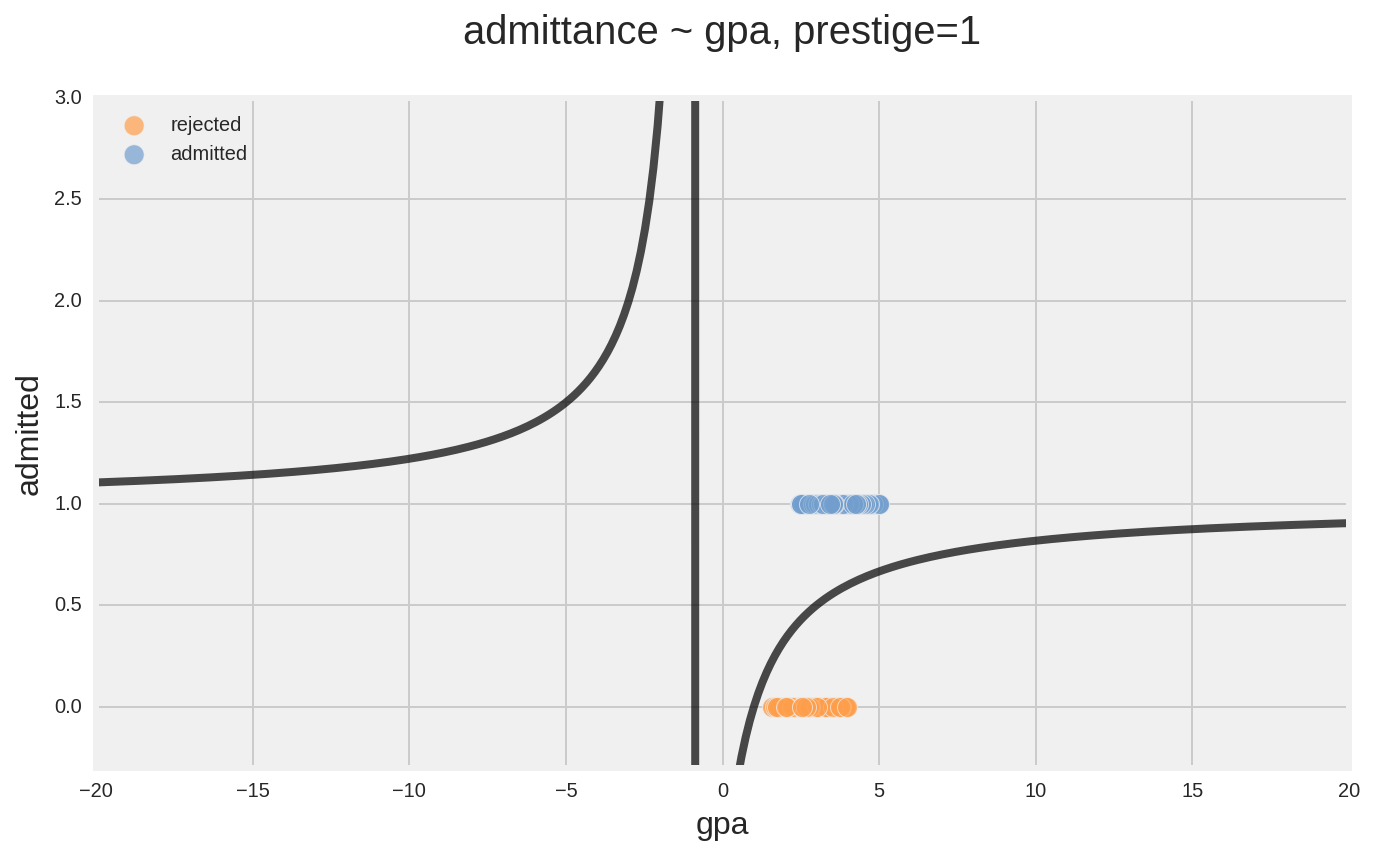

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
#fig.set_size_inches(6,5)

# plot the regression line for admit ~ gpa
x_vals = np.linspace(-20,20,300)
y_vals = min_betas.x[0] + min_betas.x[1]*x_vals
y_vals = pred_to_odds(y_vals)

ax.plot(x_vals, y_vals, color='black', alpha=0.7, lw=4)

# do one scatter plot for each type of wine:
ax.scatter(admit.gpa[admit.admit == 0],
           admit.admit[admit.admit == 0],
           c=colors['orange'], s=100, alpha=0.7,
           label='rejected')

ax.scatter(admit.gpa[admit.admit == 1],
           admit.admit[admit.admit == 1],
           c=colors['blue'], s=100, alpha=0.7,
           label='admitted')

ax.set_ylabel('admitted', fontsize=16)
ax.set_xlabel('gpa', fontsize=16)
ax.set_title('admittance ~ gpa, prestige=1\n', fontsize=20)

ax.set_xlim([-20,20])
ax.set_ylim([-.3, 3])

plt.legend(loc='upper left')
plt.show()

---

### 9. Step 2: Log odds (natural logarithm of the odds ratio)

If we take the natural logarithm of a variable that falls between 0 and infinity, we can actually transform it into a variable that falls between the range negative infinity and infinity.

This is because taking the logarithm of fractions results in negative numbers.

The regression can now predict any negative or positive number, and we can convert it back into the odds ratio.

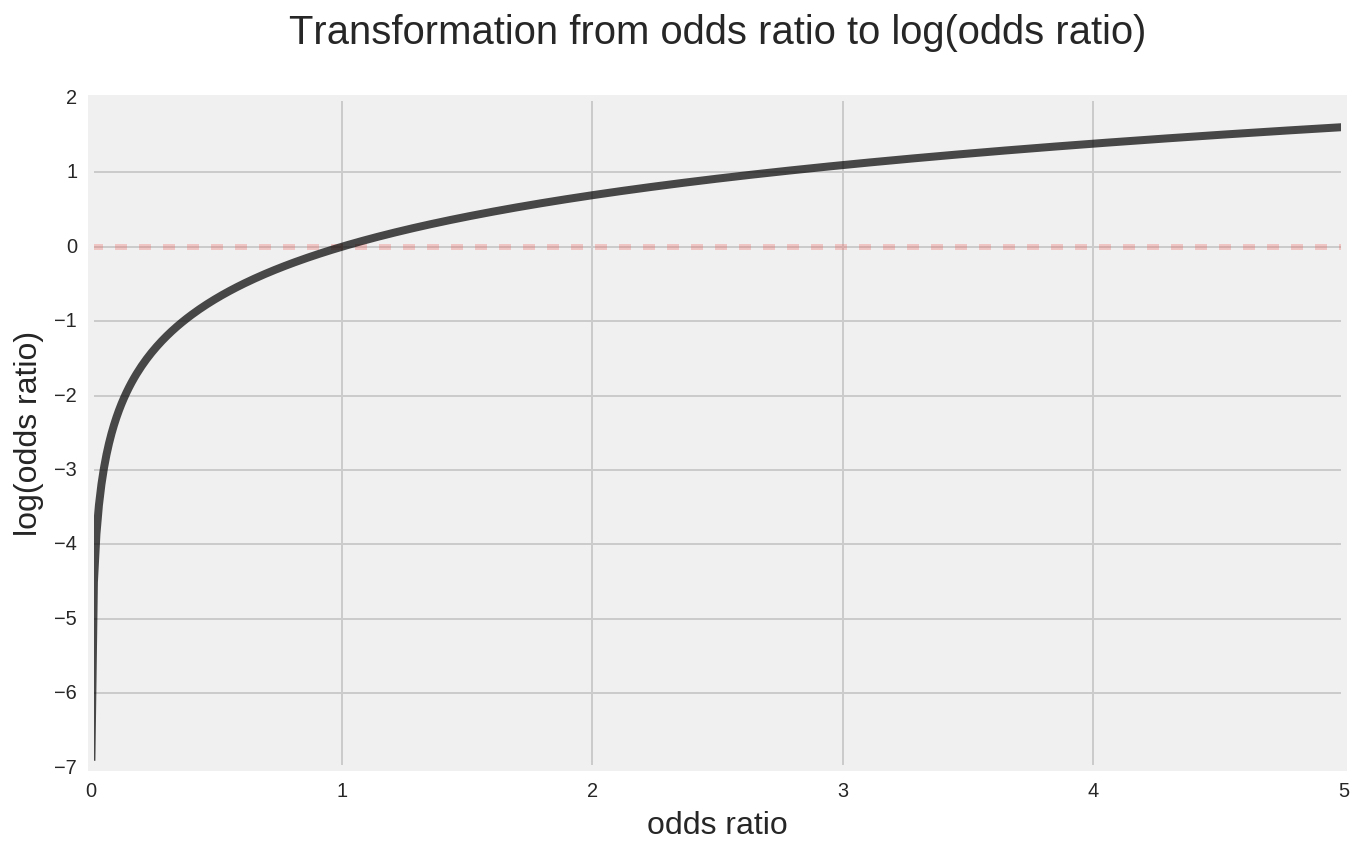

In [30]:
xs = np.linspace(0.001, 5, 500)
ys = np.log(xs)

plt.figure(figsize=[10,6])
plt.axhline(y=0, linewidth=3, c=colors['red'], ls='dashed', alpha=0.3)
plt.plot(xs, ys, lw=4, c='black', alpha=0.7)

plt.xlabel('odds ratio', fontsize=16)
plt.ylabel('log(odds ratio)', fontsize=16)
plt.title('Transformation from odds ratio to log(odds ratio)\n',fontsize=20)

---

## 10. The logit link function

The combination of converting the probability to an odds ratio and taking the logarithm of that is called the **logit link function**, and is what regression uses to estimate probability:


### $$\text{logit}\big(E[y]\big) = \text{logit}\big(P(y=1)\big) = log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) =  \beta_0 + \sum_{j}^p\beta_jx_j$$



In [31]:
logreg = LogisticRegression()
logreg.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
print 'Logreg intercept:', logreg.intercept_
print 'Logreg coef(s):', logreg.coef_
print 'Logreg predicted probabilities:', logreg.predict_proba(x[0.5,:])

Logreg intercept: [-10.27761858]
Logreg coef(s): [[ 3.03812062]]
Logreg predicted probabilities: [[ 0.01803753  0.98196247]]


/home/llevin/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/llevin/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


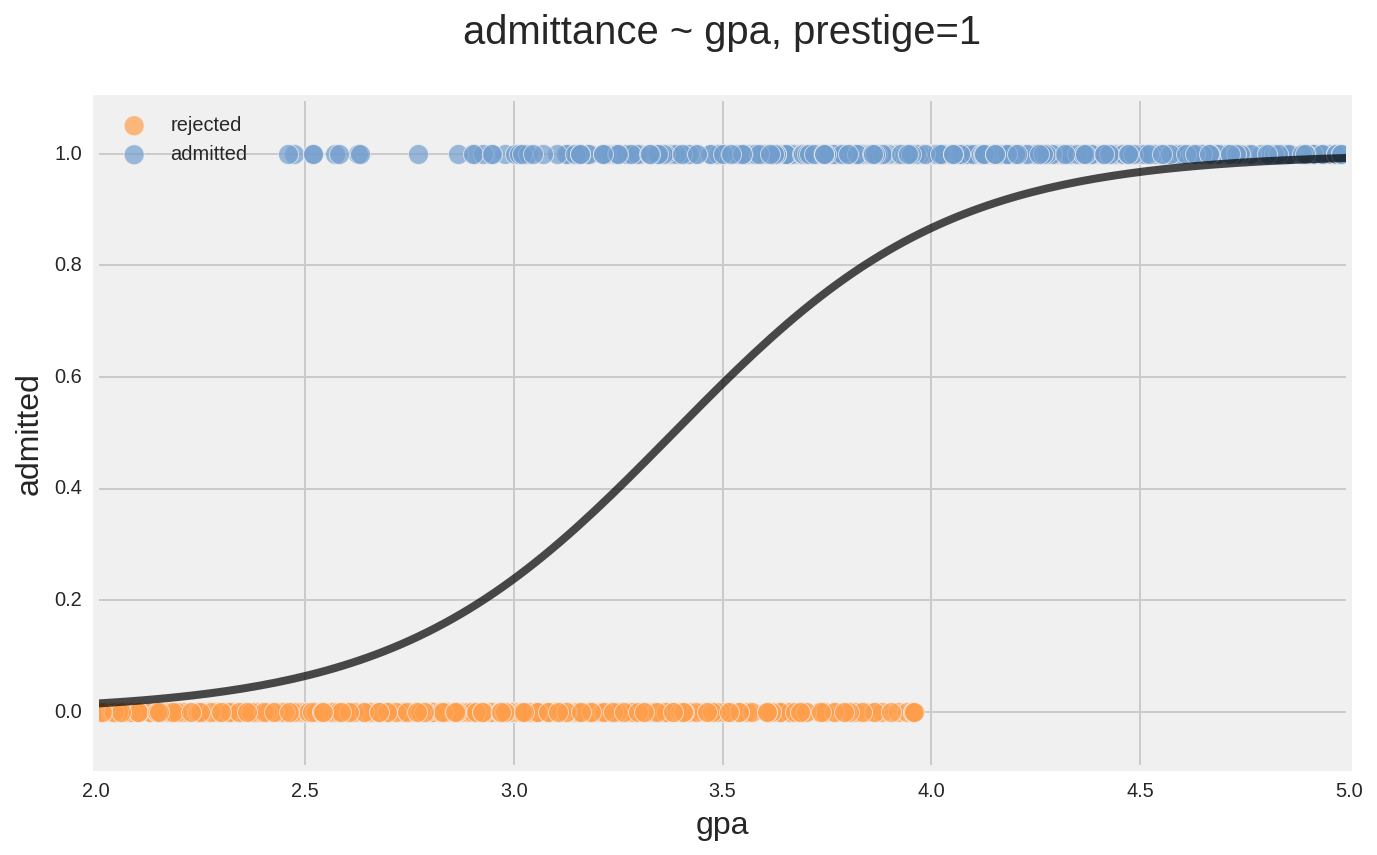

In [36]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the logreg regression line for admit ~ gpa
x_vals = np.linspace(-1.,5.,300)
y_pp = logreg.predict_proba(x_vals[:, np.newaxis])[:,1]

ax.plot(x_vals, y_pp, color='black', alpha=0.7, lw=4)

# do one scatter plot for each type of wine:
ax.scatter(admit.gpa[admit.admit == 0],
           admit.admit[admit.admit == 0],
           c=colors['orange'], s=100, alpha=0.7,
           label='rejected')

ax.scatter(admit.gpa[admit.admit == 1],
           admit.admit[admit.admit == 1],
           c=colors['blue'], s=100, alpha=0.7,
           label='admitted')

# ax.axvline(xval_chance, lw=3, color=colors['red'], ls='dashed',
#            label='gpa where P(y = 1) = 0.5')

ax.set_ylabel('admitted', fontsize=16)
ax.set_xlabel('gpa', fontsize=16)
ax.set_title('admittance ~ gpa, prestige=1\n', fontsize=20)

ax.set_xlim([2.,5.])
ax.set_ylim([-0.1, 1.1])

plt.legend(loc='upper left')
plt.show()

---

### 11. How do we minimize the RSS? Inverting the logit link function with the "logistic"

The inverse function of the logit is called the **logistic function**. 

By inverting the logit, we can have the right side of our regression equation explicitly solving for $P(y = 1)$:

### $$P(y=1) = logit^{-1}\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)$$

Where:

### $$logit^{-1}(a) = logistic(a) = \frac{e^{a}}{e^{a} + 1}$$ 

Giving us:

### $$P(y=1) = \frac{e^{\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)}}{e^{\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)}+1}$$

---

### 11. Interpreting logistic regression coefficients.

The interpretation of logistic regression coefficients can be counter-intuitive. 

**To make it easier, start by centering your predictor variables (subtracting the mean):**

#### Why does centering matter?

Centering helps a lot because now the "baseline" for the predictor, the value at 0, is the mean of the predictor. So, in our case, when gpa = 0 this is the average gpa across students.

After re-running the regression we can take a look at the coefficients:

In [15]:
#print 'Logreg intercept:', #?
#print 'Logreg coef(s):', #?

#### Meaning of the betas in log odds

Remember that our values are in terms of log-odds. 

> If $\beta_1$ is 0, then $\beta_0$ represents the log odds of admittance for a student with an average gpa.

> $\beta_1$ is the effect of a unit increase in gpa on the log odds of admittance. 

This sucks because log odds are hard to interpret. Luckily though, we can apply the logistic transform to get the probability of admittance at different $\beta$ values.

The probability of admittance with an average gpa:

In [16]:
#print 'average gpa:', #?
#print 'P(admitted | average gpa):', 

In [17]:
#print 'gpa = 2.5, difference from mean:', #?
#print 'P(admitted | gpa = 2.5):', #?

In [18]:
#print 'gpa = 4, difference from mean:', #?
#print 'P(admitted | gpa = 4):', #?

** With more coefficients, setting $\beta$ values other than the one of interest to zero (except the intercept) will let you see the change in probability as the corresponding $x$ variable changes.**